In [1]:
import numpy as np,pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2

In [2]:
# get the directories of images
train_img = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/train'
test_img = '/kaggle/input/cifake-real-and-ai-generated-synthetic-images/test'

weight,height = 32,32
batch_size = 32

generator = ImageDataGenerator(
    rescale = 1.0/255
)
test_data_gen = ImageDataGenerator(rescale = 1.0/255)

train_Dataset = generator.flow_from_directory(
    train_img,
    target_size = (weight,height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True
)

test_Dataset = test_data_gen.flow_from_directory(
    test_img,
    target_size = (weight,height),
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [3]:
train_Dataset.class_indices

{'FAKE': 0, 'REAL': 1}

# Model(CNN)

In [4]:
# Define the model
model = models.Sequential()

# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(weight, height, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with 1 neuron (binary classification)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

In [5]:
# Save best model
weight_path = '/kaggle/working/'

model_checkpoint = ModelCheckpoint(
    filepath = weight_path,
    save_best_only = True,
    save_weights_only = True,
    mode = 'max',
    monitor = 'val_accuracy'
)

# Run Model

idk, why kaggle isn't using GPU here, run 5-10 epochs atleast.

In [6]:
model.fit(train_Dataset, 
                    epochs=2, 
                    validation_data=test_Dataset,
                    callbacks=[model_checkpoint]
                   )

Epoch 1/2
3125/3125 [==============================] - 561s 179ms/step - loss: 0.3404 - accuracy: 0.8510 - val_loss: 0.2416 - val_accuracy: 0.9030
Epoch 2/2
3125/3125 [==============================] - 190s 61ms/step - loss: 0.2282 - accuracy: 0.9084 - val_loss: 0.2030 - val_accuracy: 0.9143


In [7]:
# load best weights to model
model.load_weights(weight_path)

# make prediction
predictions = model.predict(test_Dataset)

625/625 [==============================] - 23s 37ms/step


In [8]:
binary_predictions = (predictions > 0.5).astype(int)
binary_predictions

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     10000
           1       0.93      0.89      0.91     10000

    accuracy                           0.91     20000
   macro avg       0.92      0.91      0.91     20000
weighted avg       0.92      0.91      0.91     20000



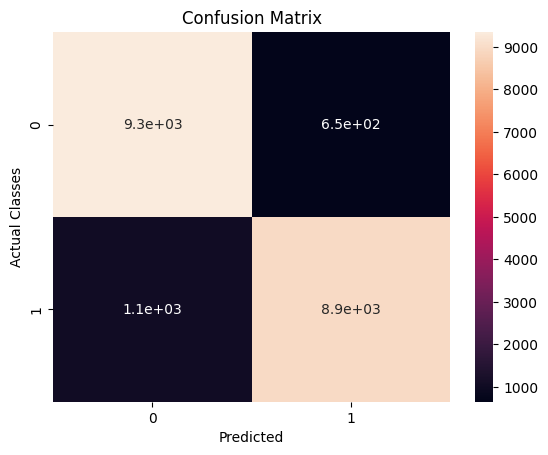

In [9]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have true labels (ground truth)
true_labels = test_Dataset.classes

# Generate a confusion matrix
sns.heatmap(confusion_matrix(true_labels, binary_predictions), annot=True)

# Print classification report
print(classification_report(true_labels, binary_predictions))

plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual Classes')
plt.show()